Loaded 240 images of class CHEETAH
Loaded 238 images of class OCELOT
Loaded 190 images of class CARACAL
Loaded 233 images of class LIONS
Loaded 242 images of class TIGER
Loaded 241 images of class PUMA
Loaded 1384 images total.
x shape: (1384, 224, 224, 3), y shape:(1384, 6)


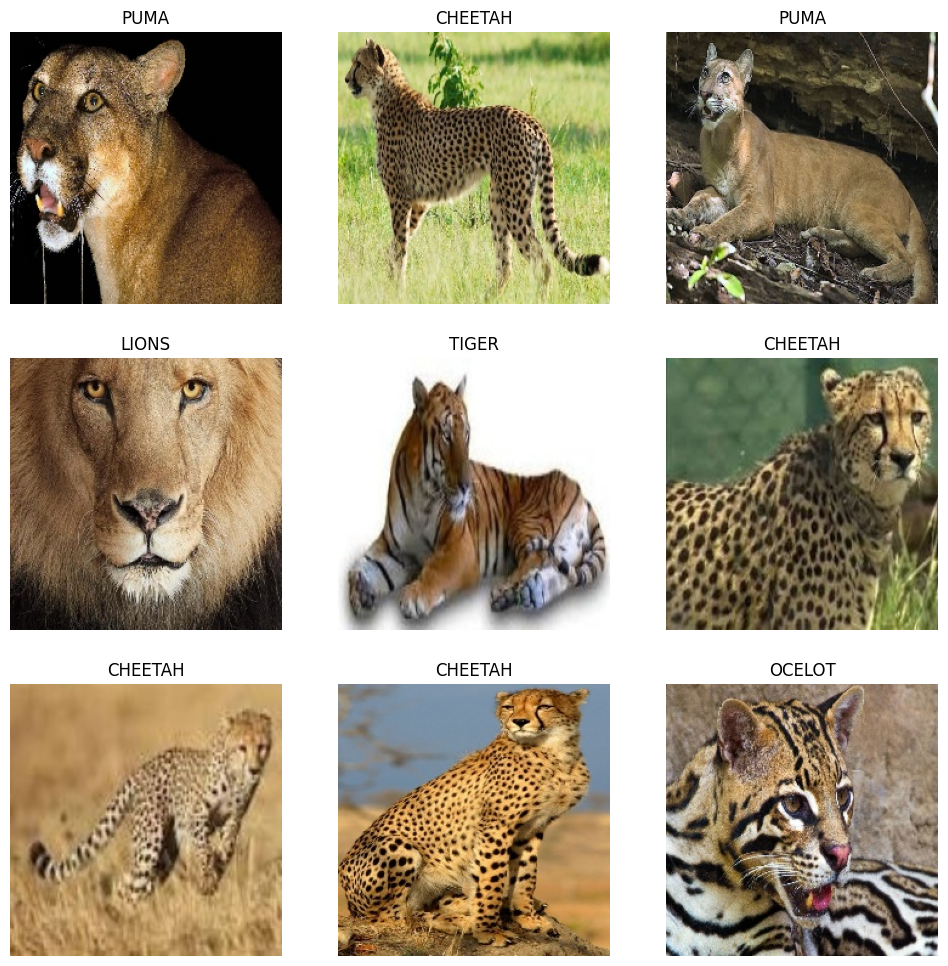

In [4]:
import sys
import os
import torch

from src.utils import *


# # Create new Dataset objects for the training and test datasets
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, data, transform=None):
#         self.data = data
#         self.transform = transform

#     def __getitem__(self, index):
#         x, y = self.data[index]
#         if self.transform:
#             x = self.transform(x)
#         return x, y

#     def __len__(self):
#         return len(self.data)


imgs, labels = load_imgs('./Dataset', ['CHEETAH' ,'OCELOT', 'CARACAL', 'LIONS', 'TIGER', 'PUMA'])
x, y = make_dataset(imgs, labels, label_to_idx, (224,224))
print('x shape: {}, y shape:{}'.format(x.shape, y.shape))
plot_sample(imgs, labels, 3, 3, resize=(224, 224))

In [6]:
################### Task 1 ###################
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

#np.random.seed(0)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class FFNN(nn.Module):
    def __init__(self, shape, classes, downscale=1):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(shape, 512 // downscale)
        self.fc2 = nn.Linear(512 // downscale, 512 // downscale)
        self.output = nn.Linear(512 // downscale, classes)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.gelu(self.fc1(x))
        x = self.gelu(self.fc2(x))
        x = self.output(x)
        return x
    
# def t1model(shape, classes, downscale=1):
#     model = Sequential()
#     model.add(Dense(512//downscale, activation=gelu, input_shape=shape))
#     model.add(Dense(512//downscale, activation=gelu))
#     # Adds softmax output layer for multi-class classification
#     model.add(Dense(classes, activation='softmax'))
#     model.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])
#     return model

#### Process dataset
## 2. Normalize each pixel of each channel so that the range is [0,1]
X = x / 255.0

## 3. Flatten the images using tf.reshape
X_flat = X.reshape(X.shape[0], -1)

## Split the dataset into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, train_size=0.8, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

print("Process dataset done!")
print('X_train.shape: {}'.format(X_train.shape))
print('X_val.shape: {}'.format(X_val.shape))
print('X_test.shape: {}'.format(X_test.shape))
print('X_flat.shape: {}'.format(X_flat.shape[1:]))
print("Image size (vectorized): {}".format(X_train.shape[1]))
####


## 4. Build a fully connected neural network
model = FFNN(X_flat.shape[1], y.shape[1], downscale=1)
summary(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

BATCH_SIZE = 32
n_epochs = 100

trainset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                          torch.tensor(y_train, dtype=torch.float32))
testset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                         torch.tensor(y_test, dtype=torch.float32))

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False)

testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# 5. Train the model and plot training and validation accuracies
# early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

def train(model, criterion, optimizer, train_loader, n_epochs, device):
    training_losses = []

    train_length = len(trainloader)
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.

        for x, y in train_loader:           # Access the training data
            optimizer.zero_grad()           # Zero the gradients
            x, y = x.to(device), y.to(device)
            y_pred = model(x)               # Forward passs
            loss = criterion(y_pred, y)
            loss.backward()                 # Compute the gradients
            optimizer.step()                # Update the weights

            train_loss += loss.item()
        training_losses.append(train_loss/train_length) # Save the loss for plotting

    return training_losses

training_losses = train(model, criterion, optimizer, trainloader, n_epochs, device)

plt.plot(training_losses)
plt.grid(alpha=0.5)
plt.show()

predictions = []
actual = []

with torch.no_grad():
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        for i in range(len(y_pred)):
          predictions.append(y_pred[i].item())
          actual.append(y[i].item())

preds = np.array(predictions)
actual = np.array(actual)

mse = np.square(inv_scale(preds) - inv_scale(actual)).mean()
print(f"TEST MSE: {mse}")
mae = np.abs(inv_scale(preds) - inv_scale(actual)).mean()
print(f"TEST MAE: {mae}")
y_pred = model(torch.tensor(x_test, dtype=torch.float32, device=device)).cpu().detach().numpy()

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), inv_scale(y_test), label="actual")
plt.plot(np.arange(y_test.shape[0]), inv_scale(y_pred), label="pred")
plt.legend()
plt.show()
# # Plot training and validation errors
# plt.figure()
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.plot(history.history['loss'], label='Train error')
# plt.plot(history.history['val_loss'], label='Validation error')
# plt.axvline(np.argmin(history.history['val_loss']), linestyle='--', color='gray', label='Min validation error')
# plt.legend(loc='upper left')
# # plt.savefig('/content/drive/MyDrive/HW2/out/T1.model_loss.png')
# plt.show()

# # Plot training and validation accuracies
# plt.figure()
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.plot(history.history['accuracy'], label='Train accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation accuracy')
# plt.legend(loc='upper left')
# # plt.savefig('/content/drive/MyDrive/HW2/out/T1.model_accuracy.png')
# plt.show()


# # 6. Assess the performance of the model on test set
# loss, acc = t1model.evaluate(X_test, y_test)
# print('Test loss: {}, Test accuracy: {}'.format(loss, acc))

# y_pred = t1model.predict(X_test)
# y_pred = np.round(y_pred)


# t1model.save('/content/drive/MyDrive/HW2/T1_model.h5')
# f = open("/content/drive/MyDrive/HW2/out/T1.model_test_loss.tex", "w")
# f.write(f"{loss:.5f}")
# f.close()
# f = open("/content/drive/MyDrive/HW2/out/T1.model_test_accuracy.tex", "w")
# f.write(f"{acc:.5f}")
# f.close()

cpu
Process dataset done!
X_train.shape: (1107, 150528)
X_val.shape: (138, 150528)
X_test.shape: (139, 150528)
X_flat.shape: (150528,)
Image size (vectorized): 150528
Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            77,070,848
├─Linear: 1-2                            262,656
├─Linear: 1-3                            3,078
├─GELU: 1-4                              --
Total params: 77,336,582
Trainable params: 77,336,582
Non-trainable params: 0


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
################### Task 2 ###################
# TODO

In [ ]:
################### Task 3 ###################
import torch.nn as nn
import torchvision.models as models

class CuttedModifiedVGG19(nn.Module):
    def __init__(self):
        super(CuttedModifiedVGG19, self).__init__()
        # Load the pre-trained VGG19 model
        vgg19 = models.vgg19(pretrained=True)
        # you can see the VGG19 detailed architecutre
        print(vgg19)
        # Extract the feature extractor part of VGG19 (all layers except the classifier)
        # TODO specify your cut layer
        self.cut_value = ...
        self.features =  nn.Sequential(*list(vgg19.features.children())[:self.cut_value]) #vgg19.features
        
        # check your new model based on the cut
        print(self.features)
        
       
        for param in self.features.parameters():
            param.requires_grad = False
            
      # TODO Initialize your layers
        
        
    def forward(self, x):
        # Pass input through VGG19 feature extractor
        x = self.features(x)
        
        # TODO Forward your layers
        
        
        return x

# TODO Training LOOP